<a href="https://colab.research.google.com/github/milvus-io/bootcamp/blob/master/bootcamp/tutorials/integration/openai_agents_milvus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>   <a href="https://github.com/milvus-io/bootcamp/blob/master/bootcamp/tutorials/integration/openai_agents_milvus.ipynb" target="_blank">
    <img src="https://img.shields.io/badge/View%20on%20GitHub-555555?style=flat&logo=github&logoColor=white" alt="GitHub Repository"/>
</a>


# Milvus Integration with OpenAI Agents: A Step-by-Step Guide

This notebook shows how to create an agent that can query Milvus using natural language through Function Calling. We'll combine OpenAI's Agents framework with Milvus's powerful vector search capabilities to create a nice search experience.

## OpenAI Agents 

The OpenAI Agents SDK enables you to build agentic AI apps in a lightweight, easy-to-use package with very few abstractions. It's a production-ready upgrade of their previous experimentation for agents, Swarm. The Agents SDK has a very small set of primitives:

* Agents, which are LLMs equipped with instructions and tools
* Handoffs, which allow agents to delegate to other agents for specific tasks
* Guardrails, which enable the inputs to agents to be validated

In combination with Python, these primitives are powerful enough to express complex relationships between tools and agents, and allow you to build real-world applications without a steep learning curve. In addition, the SDK comes with built-in tracing that lets you visualize and debug your agentic flows, as well as evaluate them and even fine-tune models for your application.

![](../../../images/openai-agent.png)

## Milvus

Milvus is a high-performance, highly scalable Open-Source vector database that runs efficiently across a wide range of environments, from a laptop to large-scale distributed systems. It is available as both open-source software and a [Cloud Offering](https://zilliz.com/).

## Setup and Dependencies

First, we need to set up our environment with the necessary libraries and initialize asyncio for Jupyter compatibility.

In [1]:
! pip install openai pymilvus pydantic nest_asyncio

> If you are using Google Colab, to enable dependencies just installed, you may need to **restart the runtime** (click on the "Runtime" menu at the top of the screen, and select "Restart session" from the dropdown menu).


In [1]:
import asyncio
import nest_asyncio
from dotenv import load_dotenv

load_dotenv()

nest_asyncio.apply()

We will use the models from OpenAI. You should prepare the [api key](https://platform.openai.com/docs/quickstart) `OPENAI_API_KEY` as an environment variable.

In [2]:
import os

os.environ["OPENAI_API_KEY"] = "sk-***********"

## Connecting to Milvus and Creating a Schema

Now we'll connect to our Milvus instance and create a schema for our collection. This schema will define the structure of our data, including:
- An ID field as the primary key
- A text field to store our document content
- A sparse vector field to store the BM25 embeddings

### Full-Text Search in Milvus 2.5
* Unified system for both vector and keyword search (unified APIs)
* Built-in sparse-BM25 algorithm (similar as Elasticsearch use but vector based)
* No need to manually generate embeddings for keyword search

<img src="https://milvus.io/docs/v2.5.x/assets/full-text-search.png" width="70%" alt="img">

## Install Milvus with Docker 

Before running this example, make sure to install Milvus and start it with Docker, have a look at our documentation - https://milvus.io/docs/install_standalone-docker.md

In [2]:
from pymilvus import DataType, FunctionType, MilvusClient

client = MilvusClient(uri="http://localhost:19530")

schema = client.create_schema()

# Simple schema that handles both text and vectors
schema.add_field(
    field_name="id", datatype=DataType.INT64, is_primary=True, auto_id=True
)
schema.add_field(
    field_name="text", datatype=DataType.VARCHAR, max_length=1000, enable_analyzer=True
)
schema.add_field(field_name="sparse", datatype=DataType.SPARSE_FLOAT_VECTOR)

{'auto_id': False, 'description': '', 'fields': [{'name': 'id', 'description': '', 'type': <DataType.INT64: 5>, 'is_primary': True, 'auto_id': True}, {'name': 'text', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 1000, 'enable_analyzer': True}}, {'name': 'sparse', 'description': '', 'type': <DataType.SPARSE_FLOAT_VECTOR: 104>}], 'enable_dynamic_field': False}

## Setting Up BM25 for Full-Text Search

Milvus supports full-text search through BM25 functions. Here we define a function that will automatically convert our text data into sparse vector representations optimized for text search.

In [3]:
from pymilvus import Function

# Milvus handles tokenization and BM25 conversion
bm25_function = Function(
    name="text_bm25_emb",  # Function name
    input_field_names=["text"],  # Name of the VARCHAR field containing raw text data
    output_field_names=[
        "sparse"
    ],  # Name of the SPARSE_FLOAT_VECTOR field reserved to store generated embeddings
    function_type=FunctionType.BM25,
)

schema.add_function(bm25_function)

{'auto_id': False, 'description': '', 'fields': [{'name': 'id', 'description': '', 'type': <DataType.INT64: 5>, 'is_primary': True, 'auto_id': True}, {'name': 'text', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 1000, 'enable_analyzer': True}}, {'name': 'sparse', 'description': '', 'type': <DataType.SPARSE_FLOAT_VECTOR: 104>, 'is_function_output': True}], 'enable_dynamic_field': False, 'functions': [{'name': 'text_bm25_emb', 'description': '', 'type': <FunctionType.BM25: 1>, 'input_field_names': ['text'], 'output_field_names': ['sparse'], 'params': {}}]}

## Creating the Collection and Loading Sample Data

Now we'll create our collection with the schema and index parameters, then load some sample data about information retrieval and Milvus.

In [4]:
index_params = client.prepare_index_params()

index_params.add_index(field_name="sparse", index_type="AUTOINDEX", metric_type="BM25")

if client.has_collection("demo"):
    client.drop_collection("demo")

client.create_collection(
    collection_name="demo",
    schema=schema,
    index_params=index_params,
)

## 3. Loading Test Data
client.insert(
    "demo",
    [
        {
            "text": "Information retrieval helps users find relevant documents in large datasets."
        },
        {
            "text": "Search engines use information retrieval techniques to index and rank web pages."
        },
        {
            "text": "The core of IR is matching user queries with the most relevant content."
        },
        {
            "text": "Vector search is revolutionising modern information retrieval systems."
        },
        {
            "text": "Machine learning improves ranking algorithms in information retrieval."
        },
        {
            "text": "IR techniques include keyword-based search, semantic search, and vector search."
        },
        {
            "text": "Boolean retrieval is one of the earliest information retrieval methods."
        },
        {"text": "TF-IDF is a classic method used to score document relevance in IR."},
        {
            "text": "Modern IR systems integrate deep learning for better contextual understanding."
        },
        {
            "text": "Milvus is an open-source vector database designed for AI-powered search."
        },
        {
            "text": "Milvus enables fast and scalable similarity search on high-dimensional data."
        },
        {
            "text": "With Milvus, developers can build applications that support image, text, and video retrieval."
        },
        {
            "text": "Milvus integrates well with deep learning frameworks like PyTorch and TensorFlow."
        },
        {
            "text": "The core of Milvus is optimised for approximate nearest neighbour (ANN) search."
        },
        {
            "text": "Milvus supports hybrid search combining structured and unstructured data."
        },
        {
            "text": "Large-scale AI applications rely on Milvus for efficient vector retrieval."
        },
        {"text": "Milvus makes it easy to perform high-speed similarity searches."},
        {"text": "Cloud-native by design, Milvus scales effortlessly with demand."},
        {
            "text": "Milvus powers applications in recommendation systems, fraud detection, and genomics."
        },
        {
            "text": "The latest version of Milvus introduces faster indexing and lower latency."
        },
        {"text": "Milvus supports HNSW, IVF_FLAT, and other popular ANN algorithms."},
        {
            "text": "Vector embeddings from models like OpenAI’s CLIP can be indexed in Milvus."
        },
        {
            "text": "Milvus has built-in support for multi-tenancy in enterprise use cases."
        },
        {
            "text": "The Milvus community actively contributes to improving its performance."
        },
        {
            "text": "Milvus integrates with data pipelines like Apache Kafka for real-time updates."
        },
        {
            "text": "Using Milvus, companies can enhance search experiences with vector search."
        },
        {
            "text": "Milvus plays a crucial role in powering AI search in medical research."
        },
        {"text": "Milvus integrates with LangChain for advanced RAG pipelines."},
        {
            "text": "Open-source contributors continue to enhance Milvus’ search performance."
        },
        {
            "text": "Multi-modal search in Milvus enables applications beyond text and images."
        },
        {"text": "Milvus has an intuitive REST API for easy integration."},
        {"text": "Milvus’ FAISS and HNSW backends provide flexibility in indexing."},
        {
            "text": "The architecture of Milvus ensures fault tolerance and high availability."
        },
        {"text": "Milvus integrates seamlessly with LLM-based applications."},
        {"text": "Startups leverage Milvus to build next-gen AI-powered products."},
        {"text": "Milvus Cloud offers a managed solution for vector search at scale."},
        {
            "text": "The future of AI search is being shaped by Milvus and similar vector databases."
        },
    ],
)

{'insert_count': 37, 'ids': [456486814660619140, 456486814660619141, 456486814660619142, 456486814660619143, 456486814660619144, 456486814660619145, 456486814660619146, 456486814660619147, 456486814660619148, 456486814660619149, 456486814660619150, 456486814660619151, 456486814660619152, 456486814660619153, 456486814660619154, 456486814660619155, 456486814660619156, 456486814660619157, 456486814660619158, 456486814660619159, 456486814660619160, 456486814660619161, 456486814660619162, 456486814660619163, 456486814660619164, 456486814660619165, 456486814660619166, 456486814660619167, 456486814660619168, 456486814660619169, 456486814660619170, 456486814660619171, 456486814660619172, 456486814660619173, 456486814660619174, 456486814660619175, 456486814660619176], 'cost': 0}

## Defining Output Types for Structured Results

To make our search results more structured and easier to work with, we'll define Pydantic models that specify the format of our search results.

In [5]:
from pydantic import BaseModel


# Simplified output model for search results
class MilvusSearchResult(BaseModel):
    id: int
    text: str


class MilvusSearchResults(BaseModel):
    results: list[MilvusSearchResult]
    query: str

## Creating a Custom Search Tool

Next, we'll create a custom function tool that our agent can use to search the Milvus database. This tool will:
1. Accept a collection name, query text, and limit parameter
2. Execute a BM25 search against the Milvus collection
3. Return the results in a structured format

In [6]:
import json
from typing import Any
from pymilvus import MilvusClient
from agents import function_tool, RunContextWrapper


@function_tool
async def search_milvus_text(
    ctx: RunContextWrapper[Any], collection_name: str, query_text: str, limit: int
) -> str:
    """Search for text documents in a Milvus collection using full text search.

    Args:
        collection_name: Name of the Milvus collection to search.
        query_text: The text query to search for.
        limit: Maximum number of results to return.
    """
    try:
        # Initialize Milvus client
        client = MilvusClient()

        # Prepare search parameters for BM25
        search_params = {"metric_type": "BM25", "params": {"drop_ratio_search": 0.2}}

        # Execute search with text query
        results = client.search(
            collection_name=collection_name,
            data=[query_text],
            anns_field="sparse",
            limit=limit,
            search_params=search_params,
            output_fields=["text"],
        )
        return json.dumps(
            {"results": results, "query": query_text, "collection": collection_name}
        )

    except Exception as e:
        print(f"Exception is: {e}")
        return f"Error searching Milvus: {str(e)}"

## Building the Agent

Now we'll create an agent that can use our search tool. We'll give it instructions on how to handle search requests and specify that it should return results in our structured format.

In [7]:
from agents import Agent, Runner, WebSearchTool, trace


async def main():
    agent = Agent(
        name="Milvus Searcher",
        instructions="""
        You are a helpful agent that can search through Milvus vector database using full text search. Return the results in a structured format.
        """,
        tools=[
            WebSearchTool(user_location={"type": "approximate", "city": "New York"}),
            search_milvus_text,
        ],
        output_type=MilvusSearchResults,
    )

    with trace("Milvus search example"):
        result = await Runner.run(
            agent,
            "Find documents in the 'demo' collection that are similar to this concept: 'information retrieval'",
        )
        # print(result.final_output.results)
        formatted_results = "\n".join(
            f"{i+1}. ID: {res.id}, Text: {res.text}"
            for i, res in enumerate(result.final_output.results)
        )
        print(f"Search results:\n{formatted_results}")

In [8]:
asyncio.run(main())

Search results:
1. ID: 456486814660619146, Text: Boolean retrieval is one of the earliest information retrieval methods.
2. ID: 456486814660619144, Text: Machine learning improves ranking algorithms in information retrieval.
3. ID: 456486814660619143, Text: Vector search is revolutionising modern information retrieval systems.
4. ID: 456486814660619140, Text: Information retrieval helps users find relevant documents in large datasets.
5. ID: 456486814660619141, Text: Search engines use information retrieval techniques to index and rank web pages.


# ⭐️ Github
We hope you liked this tutorial showcasing how to use Milvus with OpenAI Agents. If you liked it and our project, please give us a star on Github! ⭐

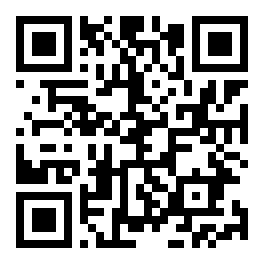

# 🤝 Add me on Linkedin!
If you have some questions related to Milvus, GenAI, etc, I am Stephen Batifol, you can add me on LinkedIn and I'll gladly help you.

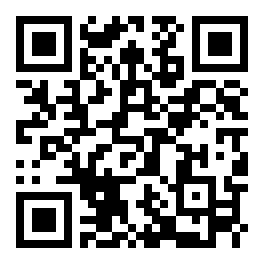

# 💬 Join our Discord

If you're interested in learning more about Milvus or you wanna share some feedback, feel free to join our [Discord channel](https://zilliz.com/discord).